## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
from keras.datasets import cifar10

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準
save_best_only: 是否只要儲存最好的


"""
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

# 導入optimizer並開始訓練
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

pred_final = model.predict(x_test)

# Load back
model = keras.models.load_model("./tmp.h5")
pre_loadback = model.predict(x_test)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_27 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_28 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

Epoch 47/50
49/49 [==============================] - 4s 72ms/step - loss: 0.5586 - accuracy: 0.8355 - val_loss: 1.6532 - val_accuracy: 0.4903
Epoch 48/50
49/49 [==============================] - 4s 72ms/step - loss: 0.5414 - accuracy: 0.8440 - val_loss: 1.6705 - val_accuracy: 0.4893
Epoch 49/50
49/49 [==============================] - 4s 74ms/step - loss: 0.5271 - accuracy: 0.8481 - val_loss: 1.7071 - val_accuracy: 0.4940
Epoch 50/50
313/313 [==============================] - 2s 4ms/step - loss: 1.4610 - accuracy: 0.4934
1.4609547853469849 0.4934000074863434


In [25]:

from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=1), y_pred=pred_final.argmax(axis=1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=1), y_pred=pre_loadback.argmax(axis=1))

print('Accuracy of final weights: %.3f' %final_model_acc)
print('Accuracy of Best weights: %.3f' %loadback_acc)


Accuracy of final weights: 0.487
Accuracy of Best weights: 0.493


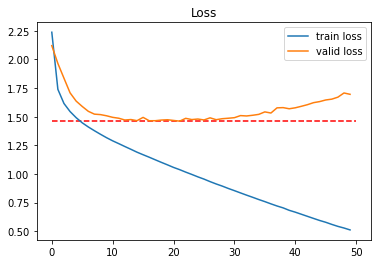

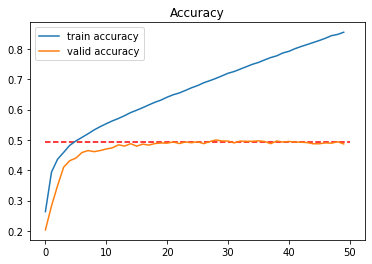

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

# 作業1
1. save_best_only =False時，Vaild Loss=1.67，不像範例是1.48多，沒抓到最好的模型
2. 有用save_best_only = True時，Vaild Loss=1.44。
3. 要用ModelCheckPoint就要用True，否則存不到最好的權重就沒意義了
# 作業2
1. 比較Final 和 Best的Accuracy 差了一些，訓練到最後不一定比較好
